In [2]:
# one video with HOG (with comparetor)
# copy 3 parameters from below 

import cv2
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from math import sqrt  
from skimage import feature

def mask_idk(flow):# mask for pixels whose motion we are unsure of
    vector_length = np.linalg.norm(flow,axis=2)
    mask=vector_length<0.05
    return mask

def edges(array,bins):
    edges=[]
    i=array.min()
    while i <= array.max():
        edges.append(i)
        i+=(array.max()-array.min())/bins # set the number of bins to be 100
    edges=np.array(edges)
    return edges
                          
def calCameraMotion (flow):
    # calculate camera motion from filtered pixels
    mask1=mask_idk(flow) 
    #flow_pruned=flow[mask1]                                                     # moving camera
    flow_pruned=flow                                                           # stationary camera 
    
    # 2D Histogram 
    x=flow_pruned[:,0].flatten()
    y=flow_pruned[:,1].flatten()
    xedges=edges(x,100)
    yedges=edges(y,100)
    
    H,xedges,yedges=np.histogram2d(x, y,bins=(xedges,yedges))
    idx = list(H.flatten()).index(H.max()) #get 1D index
    x_idx, y_idx = idx // H.shape[1], idx % H.shape[1] #get 2D index
    
    return xedges[x_idx],yedges[y_idx]

def mask_camera(flow):
    dx,dy=calCameraMotion(flow)
    vector_camera=sqrt(dx**2 + dy**2)
    vector_length = np.linalg.norm(flow,axis=2)
    #uncertainty=vector_camera*16086+5.4526                            #uncertainty: relationship determined through experimentation 
    uncertainty=1
    mask=(vector_length > vector_camera - uncertainty) & (vector_length < vector_camera + uncertainty) & (vector_length > 0.05)#pixels in the range of camera motion & not belong to idk
    return mask

def mask_object(flow): #pixels unclassified 
    mask1=mask_idk(flow)
    mask2=mask_camera(flow)
    mask_object=np.logical_or(mask1,mask2)
    mask_object=~mask_object #get opposite value
    return mask_object

def imageMorphology(img):
    kernel = np.ones((40,40),np.uint8)                                  # parameter determined though tests
    closing = cv2.morphologyEx(img, cv2.MORPH_CLOSE, kernel) #dilation followed by erosion 
    return closing

def boundingBox(img,frame,background):
    thresh=imageMorphology(img)
    #ret,thresh = cv2.threshold(img,128,255,0) <--no need as prvs is alr a binary image 
    contours,hierarchy = cv2.findContours(thresh,cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
    minArea=200*250                                                     # upon adjustment 
     
    stencil = np.zeros(background.shape).astype(background.dtype)
    frame_box=frame  
    hog_list = []
    location_list = []
    iou_list = []
    
    for cnt in contours:
        x,y,w,h = cv2.boundingRect(cnt)
        area = cv2.contourArea(cnt)
        if area > minArea:
            frame_box= cv2.rectangle(frame, (x,y),(x+w,y+h), (0,255,0), 5)
            location_list.append((x+5,y+40))
            
            box_countours=[np.array([[x,y],[x+w,y],[x+w,y+h],[x,y+h]])]
            cv2.fillPoly(stencil, box_countours, [255,255,255])
            
            # crop image to ratio of 1:2                                # assume h > w
            if h%2 == 0:
                H = h-5  
            else: 
                H = h-6
            W = int(H /2)
            X = int(x+ w/2 - W/2)
            Y = y
            
            if X<0:
                X = 0
            crop_img = frame[Y:Y+H, X:X+W] 
            resized = cv2.resize(crop_img, (64,128))

            # calculate HOG descriptor (original descriptor & descriptor image)
            hog, hog_img = feature.hog(resized, orientations=9, 
                                pixels_per_cell=(8, 8), cells_per_block=(2, 2), 
                                block_norm='L2-Hys', visualize=True, transform_sqrt=True)
            hog_list.append(hog)
            
            iou_result = cv2.bitwise_and(background, stencil) 
            iou_list.append(iou_result)
            stencil = np.zeros(background.shape).astype(background.dtype)
    
    return frame_box,hog_list,location_list,iou_list,
    
def IoU (x,y):
    intersection = np.logical_and(x, y)
    union = np.logical_or(x, y)
    iou_score = np.sum(intersection) / np.sum(union)
    return iou_score

def main():
    cv2.namedWindow('Video', cv2.WINDOW_NORMAL)
    cv2.resizeWindow('Video', 1120, 630)

    cap = cv2.VideoCapture("C:/Users/hucan/Videos/Captures/video8.MOV")         # name, mp4/MOV         
    for i in range (40):                                                        # no of times upon adjustment 
        ret, frame1 = cap.read()
    frame1 = cv2.rotate(frame1, cv2.ROTATE_90_CLOCKWISE)                          #
    frame1 = cv2.rotate(frame1, cv2.ROTATE_90_CLOCKWISE)                          #
    prvs = cv2.cvtColor(frame1,cv2.COLOR_BGR2GRAY)
    
    background=cv2.imread ("C:/Users/hucan/OneDrive/Pictures/Screenshots/background.png",0) 
    hog_full_list = []
    location_full_list = []
    iou_full_list = []
    count = -2
    item = 1
    missing_hog = []
    hog_item = {}
    
    
    while(1):
        ret, frame2 = cap.read()
        frame2 = cv2.rotate(frame2, cv2.ROTATE_90_CLOCKWISE)                          #
        frame2 = cv2.rotate(frame2, cv2.ROTATE_90_CLOCKWISE)                          #
        next = cv2.cvtColor(frame2,cv2.COLOR_BGR2GRAY)
        flow = cv2.calcOpticalFlowFarneback(prvs,next, None, 0.5, 3, 15, 3, 5, 1.2, 0)

        maskObject = mask_object(flow)
        temp=prvs
        temp[~maskObject]=0
        temp[maskObject]=255
        
        img,hog_list,location_list,iou_list = boundingBox(temp,frame1,background)
        iou_full_list.append(iou_list)
        hog_full_list.append(hog_list)
        location_full_list.append(location_list)
        count += 1
        hog_item_same = {}
        hog_item_displayed_2 = {}
        
        if count >= 0: # from second frame onwards
            for i in range (len(iou_list)): # for every object identified  
                iou_score = 0
                j = 0
                
                hog_tuple = tuple(hog_list[i])                                                            # parameter for iou and hog #
                temp = {}
                hog_item_displayed_2 = {}
                hog_item_same = {}
                
                length_j = len(iou_full_list[count])
                while iou_score < 0.5 and j < length_j: # find similar location                  
                    iou_score = IoU (iou_full_list[count][j], iou_list[i])
                    print("iou score = ",iou_score)
                    j += 1  
                
                j = j-1
                if iou_score >= 0.5 and len(iou_list)> 0 and len(hog_full_list[count])> 0: # similar location found & valid object identified in this and previous frame               
                    dist = np.linalg.norm(hog_list[i] - hog_full_list[count][j])
                    print("hog distance:",dist)
                    if dist > 8.6: # different feature -- new          
                        text = "Item" + str(item)
                        hog_item[hog_tuple] = item  
                        item += 1 
                        
                        hog_item_displayed_2[hog_tuple] = item 
                        print("Case: similar location, different features -- new")
                    else: # similar location and similar feature  
                        text = "Item" + str(hog_item[tuple(hog_full_list[count][j])]) # find existing item no
                        hog_item.pop(tuple(hog_full_list[count][j])) # update hog with old item no
                        hog_item[hog_tuple] = int(text[-1:])
                        
                        hog_item_displayed_2[hog_tuple] = int(text[-1:])
                        hog_item_same[hog_tuple] = int(text[-1:])
                        print("Case: similar location, similar features -- same object")
                else: # no similar location/ no objects identified in this/previous frame-- new -- asumption
                    k = 0
                    if len(missing_hog)>0:
                        print("length of missing hog:",len(missing_hog))
                        dist = np.linalg.norm(hog_list[i] - missing_hog[k][0])
                        k += 1
                        print("hog distance:",dist)
                        while dist > 8.6 and k < len(missing_hog):                               
                            dist = np.linalg.norm(hog_list[i] - missing_hog[k][0])
                            print("hog distance inside missing loop:",dist)
                            k += 1
                        k = k-1
                        if dist > 8.6: # no matching -- new                           
                            item += 1
                            text = "Item" + str(item)
                            hog_item[hog_tuple] = item
                             
                            
                            hog_item_displayed_2[hog_tuple] = item 
                            print("Case: no match with missing list -- new")
                        else: # missing objects reappear 
                            item = missing_hog [k][1]
                            text = "Item" + str(item)
                            hog_item[hog_tuple] = item
                            
                            hog_item_displayed_2[hog_tuple] = item 
                            print("Case: different location, same feature -- reappear")
                    else: # no missing list exist -- new  
                        text = "Item" + str(item)
                        hog_item[hog_tuple] = item
                        item += 1 
                        
                        hog_item_displayed_2[hog_tuple] = item 
                        print("Case: no missing list available -- new")
                cv2.putText(img,text,location_list[i],cv2.FONT_HERSHEY_SIMPLEX,1.5,(0,255,0),2)
            
            for hog in hog_item_displayed_1:
                item = hog_item_displayed_1[hog] 
                if item not in list(hog_item_same.values()): # if item displayed in previous frame not reidentified in current frame 
                    hog = list(hog) # convert tuple to list 
                    missing_hog.append([hog,item])
                    print("One missing object identified")
            hog_item_displayed_1 = hog_item_displayed_2.copy()
     
        else: # for the first frame
            for i in range (len(iou_list)): # loop through every identified object in the order of bounding box drawn 
                text = "Item" + str(item)
                hog_tuple = tuple(hog_list[i])
                hog_item[hog_tuple] = item 
                item += 1
                cv2.putText(img,text,location_list[i],cv2.FONT_HERSHEY_SIMPLEX,1.5,(0,255,0),2)
                print ("Case: first frame")
            hog_item_displayed_1 = hog_item.copy()
     
        print()    
        cv2.imshow('Video',img)
        k = cv2.waitKey(30) & 0xff
        if k == ord('q'):
            break
        prvs = next
        frame1=frame2

    cap.release()
    cv2.destroyAllWindows()
    
main()


Case: first frame

iou score =  0.8881360750497489
hog distance: 4.704968897492473
Case: similar location, similar features -- same object

iou score =  0.8633879781420765
hog distance: 5.6942172714892
Case: similar location, similar features -- same object

iou score =  0.895855665682669
hog distance: 5.513673227580307
Case: similar location, similar features -- same object

One missing object identified
















length of missing hog: 1
hog distance: 9.390694060059376
Case: no match with missing list -- new

iou score =  0.9828417435162063
hog distance: 4.645848794906172
Case: similar location, similar features -- same object
iou score =  0.0
length of missing hog: 1
hog distance: 8.841549238421589
Case: no match with missing list -- new
One missing object identified

iou score =  0.9764967598413773
hog distance: 4.23340294171373
Case: similar location, similar features -- same object
iou score =  0.0
iou score =  0.8448275862068966
hog distance: 6.7344786205811
Case: similar 

iou score =  0.0
iou score =  0.6701834501220376
hog distance: 8.259820514736331
Case: similar location, similar features -- same object
iou score =  0.9220338983050848
hog distance: 5.8195914818357615
Case: similar location, similar features -- same object
One missing object identified

iou score =  0.8671582397003745
hog distance: 4.878570827609246
Case: similar location, similar features -- same object
iou score =  0.0
iou score =  0.9218303826384923
hog distance: 5.128503416417676
Case: similar location, similar features -- same object

iou score =  0.8499688987701157
hog distance: 5.643722041348672
Case: similar location, similar features -- same object
One missing object identified

iou score =  0.9502196193265008
hog distance: 5.214670617783267
Case: similar location, similar features -- same object

iou score =  0.8742795778183042
hog distance: 6.510450719959024
Case: similar location, similar features -- same object

iou score =  0.9297598517254712
hog distance: 5.533102483845

In [9]:
# IoU
# copy 3 parameters 

import cv2
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from math import sqrt  

def mask_idk(flow):# mask for pixels whose motion we are unsure of
    vector_length = np.linalg.norm(flow,axis=2)
    mask=vector_length<0.05
    return mask

def edges(array,bins):
    edges=[]
    i=array.min()
    while i <= array.max():
        edges.append(i)
        i+=(array.max()-array.min())/bins # set the number of bins to be 100
    edges=np.array(edges)
    return edges
                          
def calCameraMotion (flow):
    # calculate camera motion from filtered pixels
    mask1=mask_idk(flow)
    #flow_pruned=flow[mask1]                                                   # moving camera
    flow_pruned=flow                                                           # stationary camera 
    
    # 2D Histogram 
    x=flow_pruned[:,0].flatten()
    y=flow_pruned[:,1].flatten()
    xedges=edges(x,100)
    yedges=edges(y,100)
    
    H,xedges,yedges=np.histogram2d(x, y,bins=(xedges,yedges))
    idx = list(H.flatten()).index(H.max()) #get 1D index
    x_idx, y_idx = idx // H.shape[1], idx % H.shape[1] #get 2D index
    
    return xedges[x_idx],yedges[y_idx]

def mask_camera(flow):
    dx,dy=calCameraMotion(flow)
    vector_camera=sqrt(dx**2 + dy**2)
    vector_length = np.linalg.norm(flow,axis=2)
    #uncertainty=vector_camera*16086+5.4526                            #uncertainty: relationship determined through experimentation 
    uncertainty=1 
    mask=(vector_length > vector_camera - uncertainty) & (vector_length < vector_camera + uncertainty) & (vector_length > 0.05)#pixels in the range of camera motion & not belong to idk
    return mask

def mask_object(flow): #pixels unclassified 
    mask1=mask_idk(flow)
    mask2=mask_camera(flow)
    mask_object=np.logical_or(mask1,mask2)
    mask_object=~mask_object #get opposite value
    return mask_object

def imageMorphology(img):
    kernel = np.ones((40,40),np.uint8)                                  # parameter determined though tests
    closing = cv2.morphologyEx(img, cv2.MORPH_CLOSE, kernel) #dilation followed by erosion 
    return closing

def boundingBox(img,frame,background): 
    thresh=imageMorphology(img)
    #ret,thresh = cv2.threshold(img,128,255,0) <--no need as prvs is alr a binary image 
    contours,hierarchy = cv2.findContours(thresh,cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
    minArea=60*60                                                     # upon adjustment

    frame_box=frame
    stencil = np.zeros(background.shape).astype(background.dtype)
    for cnt in contours:
        x,y,w,h = cv2.boundingRect(cnt)
        area = cv2.contourArea(cnt)
        if area > minArea:
            frame_box= cv2.rectangle(frame, (x,y),(x+w,y+h), (0,255,0), 5)
            box_countours=[np.array([[x,y],[x+w,y],[x+w,y+h],[x,y+h]])]
            cv2.fillPoly(stencil, box_countours, [255,255,255])
    result = cv2.bitwise_and(background, stencil) 
    return frame_box,result

def IoU (x,y):
    intersection = np.logical_and(x, y)
    union = np.logical_or(x, y)
    iou_score = np.sum(intersection) / np.sum(union)
    return iou_score
     
def main():
    cv2.namedWindow('Video', cv2.WINDOW_NORMAL)
    cv2.resizeWindow('Video', 1120, 630)

    cap = cv2.VideoCapture("C:/Users/hucan/Videos/Captures/video1.mp4")
    for i in range (79):                                                        # no of times upon adjustment 
        ret, frame1 = cap.read()
    prvs = cv2.cvtColor(frame1,cv2.COLOR_BGR2GRAY)
    
    background=cv2.imread ("C:/Users/hucan/OneDrive/Pictures/Screenshots/background.png",0) 
    box_result1 = background 

    while(1):
        ret, frame2 = cap.read()
        next = cv2.cvtColor(frame2,cv2.COLOR_BGR2GRAY)
        flow = cv2.calcOpticalFlowFarneback(prvs,next, None, 0.5, 3, 15, 3, 5, 1.2, 0)

        maskObject = mask_object(flow)
        temp=prvs
        temp[~maskObject]=0
        temp[maskObject]=255
        img, box_result2=boundingBox(temp,frame1,background) 
        
        iou_score = IoU (box_result1, box_result2)
        if iou_score > 0.2:
            cv2.imshow('Video',img)
        else:
            cv2.imshow('Video',frame2)
        
        k = cv2.waitKey(30) & 0xff
        if k == ord('q'):
            break
       
        prvs = next
        frame1=frame2
        box_result1=box_result2

    cap.release()
    cv2.destroyAllWindows()
    
main()


In [72]:
# one video 
# copy 3 parameters from below 

import cv2
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from math import sqrt  

def mask_idk(flow):# mask for pixels whose motion we are unsure of
    vector_length = np.linalg.norm(flow,axis=2)
    mask=vector_length<0.05
    return mask

def edges(array,bins):
    edges=[]
    i=array.min()
    while i <= array.max():
        edges.append(i)
        i+=(array.max()-array.min())/bins # set the number of bins to be 100
    edges=np.array(edges)
    return edges
                          
def calCameraMotion (flow):
    # calculate camera motion from filtered pixels
    mask1=mask_idk(flow) 
    #flow_pruned=flow[mask1]                                                   # moving camera
    flow_pruned=flow                                                           # stationary camera 
    
    # 2D Histogram 
    x=flow_pruned[:,0].flatten()
    y=flow_pruned[:,1].flatten()
    xedges=edges(x,100)
    yedges=edges(y,100)
    
    H,xedges,yedges=np.histogram2d(x, y,bins=(xedges,yedges))
    idx = list(H.flatten()).index(H.max()) #get 1D index
    x_idx, y_idx = idx // H.shape[1], idx % H.shape[1] #get 2D index
    
    return xedges[x_idx],yedges[y_idx]

def mask_camera(flow):
    dx,dy=calCameraMotion(flow)
    vector_camera=sqrt(dx**2 + dy**2)
    vector_length = np.linalg.norm(flow,axis=2)
    #uncertainty=vector_camera*16086+5.4526                            #uncertainty: relationship determined through experimentation 
    uncertainty=1
    mask=(vector_length > vector_camera - uncertainty) & (vector_length < vector_camera + uncertainty) & (vector_length > 0.05)#pixels in the range of camera motion & not belong to idk
    return mask

def mask_object(flow): #pixels unclassified 
    mask1=mask_idk(flow)
    mask2=mask_camera(flow)
    mask_object=np.logical_or(mask1,mask2)
    mask_object=~mask_object #get opposite value
    return mask_object

def imageMorphology(img):
    kernel = np.ones((40,40),np.uint8)                                  # parameter determined though tests
    closing = cv2.morphologyEx(img, cv2.MORPH_CLOSE, kernel) #dilation followed by erosion 
    return closing

def boundingBox(img,frame):
    thresh=imageMorphology(img)
    #ret,thresh = cv2.threshold(img,128,255,0) <--no need as prvs is alr a binary image 
    contours,hierarchy = cv2.findContours(thresh,cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
    minArea=200*250                                                    # upon adjustment 

    
    frame_box=frame
    for cnt in contours:
        x,y,w,h = cv2.boundingRect(cnt)
        area = cv2.contourArea(cnt)
        if area > minArea:
            frame_box= cv2.rectangle(frame, (x,y),(x+w,y+h), (0,255,0), 5)
    return frame_box
    
    
def main():
    cv2.namedWindow('Video', cv2.WINDOW_NORMAL)
    cv2.resizeWindow('Video', 1120, 630)

    cap = cv2.VideoCapture("C:/Users/hucan/Videos/Captures/video8.MOV")         # name, mp4/MOV
    #ret, frame1 = cap.read()
    for i in range (40):                                                        # no of times upon adjustment 
        ret, frame1 = cap.read()
    prvs = cv2.cvtColor(frame1,cv2.COLOR_BGR2GRAY)

    while(1):
        ret, frame2 = cap.read()
        next = cv2.cvtColor(frame2,cv2.COLOR_BGR2GRAY)
        flow = cv2.calcOpticalFlowFarneback(prvs,next, None, 0.5, 3, 15, 3, 5, 1.2, 0)

        maskObject = mask_object(flow)
        temp=prvs
        temp[~maskObject]=0
        temp[maskObject]=255
        img=boundingBox(temp,frame1)
        
        img = cv2.rotate(img, cv2.ROTATE_90_CLOCKWISE)                          #
        img = cv2.rotate(img, cv2.ROTATE_90_CLOCKWISE)                          #
        
        cv2.imshow('Video',img)
        k = cv2.waitKey(30) & 0xff
        if k == ord('q'):
            break
        prvs = next
        frame1=frame2

    cap.release()
    cv2.destroyAllWindows()
    
main()


(720, 1280, 2)

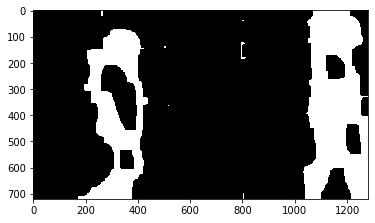

In [2]:
# one frame 

# stationary/moving camera:
# no of frame, uncertainty (prvs)
# kernel size (morphology)
# minArea (bounding box) 

import cv2
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from math import sqrt  

cap = cv2.VideoCapture("C:/Users/hucan/Videos/Captures/video8.MOV")         # name, mp4/MOV
for i in range (85):                                                        # no of times upon adjustment 
    ret, frame1 = cap.read()
prvs = cv2.cvtColor(frame1,cv2.COLOR_BGR2GRAY)
ret, frame2 = cap.read()
next = cv2.cvtColor(frame2,cv2.COLOR_BGR2GRAY)
flow = cv2.calcOpticalFlowFarneback(prvs,next, None, 0.5, 3, 15, 3, 5, 1.2, 0)

# mask for pixels whose motion we are unsure of
def mask_idk(flow):
    vector_length = np.linalg.norm(flow,axis=2)
    mask=vector_length<0.05                                                 
    return mask

def edges(array,bins):
    edges=[]
    i=array.min()
    while i <= array.max():
        edges.append(i)
        # set the number of bins to be 100
        i+=(array.max()-array.min())/bins 
    edges=np.array(edges)
    return edges
                          
def calCameraMotion (flow):
    # calculate camera motion from filtered pixels
    mask1=mask_idk(flow) 
    #flow_pruned=flow[mask1]                                                   # moving camera
    flow_pruned=flow                                                         # stationary camera 
    
    # 2D Histogram 
    x=flow_pruned[:,0].flatten()
    y=flow_pruned[:,1].flatten()
    xedges=edges(x,100)
    yedges=edges(y,100)
    
    H,xedges,yedges=np.histogram2d(x, y,bins=(xedges,yedges))
    #get 1D index
    idx = list(H.flatten()).index(H.max()) 
    #get 2D index
    x_idx, y_idx = idx // H.shape[1], idx % H.shape[1] 
    
    return xedges[x_idx],yedges[y_idx]

def mask_camera(flow):
    dx,dy=calCameraMotion(flow)
    vector_camera=sqrt(dx**2 + dy**2)
    vector_length = np.linalg.norm(flow,axis=2)
    #uncertainty=vector_camera*16086+5.4526                            #uncertainty: relationship determined through experimentation 
    uncertainty=1
    #pixels in the range of camera motion & not belong to idk
    mask=(vector_length > vector_camera - uncertainty) & (vector_length < vector_camera + uncertainty) & (vector_length > 0.05)
    return mask

#pixels unclassified 
def mask_object(flow): 
    mask1=mask_idk(flow)
    mask2=mask_camera(flow)
    mask_object=np.logical_or(mask1,mask2)
    #get opposite value
    mask_object=~mask_object 
    return mask_object

def imageMorphology(img):
    kernel = np.ones((40,40),np.uint8)                                 # parameter determined though tests 
    #dilation followed by erosion 
    closing = cv2.morphologyEx(img, cv2.MORPH_CLOSE, kernel)
    #closing = cv2.erode(img,kernel,iterations = 1)
    return closing

def boundingBox(img,frame):
    thresh=imageMorphology(img) 
    contours,hierarchy = cv2.findContours(thresh,cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
    minArea=250*250                                                    # upon adjustment 
    
    frame_box=frame
    for cnt in contours:
        x,y,w,h = cv2.boundingRect(cnt)
        area = cv2.contourArea(cnt)
        if area > minArea:
            frame_box= cv2.rectangle(frame1, (x,y),(x+w,y+h), (0,255,0), 5)
    return frame_box
    
mask_object=mask_object(flow)
prvs[~mask_object]=0
prvs[mask_object]=255


#img=prvs
img=imageMorphology(prvs)
#img=boundingBox(prvs,frame1)

img=cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
img = cv2.rotate(img, cv2.ROTATE_90_CLOCKWISE)           #
img = cv2.rotate(img, cv2.ROTATE_90_CLOCKWISE)           #
plt.imshow(img)
#flow.shape

In [18]:
# dense optical flow
# find suitable frame 

import cv2
import numpy as np
cv2.namedWindow('frame2', cv2.WINDOW_NORMAL)
cv2.resizeWindow('frame2', 1120, 630)

cap = cv2.VideoCapture("C:/Users/hucan/Videos/Captures/video7.mp4")         # name, mp4/MOV

for i in range (51):                                                        # no of times upon adjustment 
        ret, frame1 = cap.read()
prvs = cv2.cvtColor(frame1,cv2.COLOR_BGR2GRAY)
hsv = np.zeros_like(frame1)
hsv[...,1] = 255

while(1):
    ret, frame2 = cap.read()
    next = cv2.cvtColor(frame2,cv2.COLOR_BGR2GRAY)

    flow = cv2.calcOpticalFlowFarneback(prvs,next, None, 0.5, 3, 15, 3, 5, 1.2, 0)

    mag, ang = cv2.cartToPolar(flow[...,0], flow[...,1])
    hsv[...,0] = ang*180/np.pi/2
    hsv[...,2] = cv2.normalize(mag,None,0,255,cv2.NORM_MINMAX)
    rgb = cv2.cvtColor(hsv,cv2.COLOR_HSV2BGR)

    #rgb = cv2.rotate(rgb, cv2.ROTATE_90_CLOCKWISE)                                   #
    #rgb = cv2.rotate(rgb, cv2.ROTATE_90_CLOCKWISE)                                   #
    cv2.imshow('frame2',rgb)
    k = cv2.waitKey(30) & 0xff
    if k == ord('q'):
        break
    elif k == ord('s'):
        cv2.imwrite('C:/Users/hucan/Videos/Captures/frame2.png',frame2)
        cv2.imwrite('C:/Users/hucan/Videos/Captures/rgh.png',rgb)
    prvs = next

cap.release()
cv2.destroyAllWindows()